In [1]:
import pandas as pd

from sklearn.manifold import TSNE
from pathlib import Path
import joblib
import torch

import numpy as np
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [2]:
def import_raw_data(input_path):
    df = pd.read_csv(input_path, header=None)
    return df

In [3]:
input_embeddings = import_raw_data('../data/dev.csv')

In [4]:
model = TSNE(n_components=20, n_iter=500, method='exact', perplexity=40, verbose=2, random_state=42)
output_embeddings = model.fit_transform(input_embeddings)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 6.639150
[t-SNE] Iteration 50: error = 63.3019218, gradient norm = 0.0998586 (50 iterations in 767.132s)
[t-SNE] Iteration 100: error = 65.6832138, gradient norm = 0.0640841 (50 iterations in 904.739s)
[t-SNE] Iteration 150: error = 65.8543455, gradient norm = 0.0506401 (50 iterations in 851.728s)
[t-SNE] Iteration 200: error = 66.7183124, gradient norm = 0.0590515 (50 iterations in 901.460s)
[t-SNE] Iteration 250: error = 67.8909375, gradient norm = 0.0523807 (50 iterations in 861.348s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.890937
[t-SNE] Iteration 300: error = 3.9593780, gradient norm = 0.0000638 (50 iterations in 994.884s)
[t-SNE] Iteration 350: error = 3.8063509, gradient norm = 0.0000146 (50 iterations in 890.220s)
[t-SNE] Iteration 400: error = 3.7317602, gradient norm = 0.0000063 (50 iterations in 66.270s)
[t-SNE] Iteratio

In [5]:
output_embeddings = torch.from_numpy(output_embeddings)

In [6]:
def far_func(sorted_dist: torch.tensor, indices: torch.tensor):
    return sorted_dist[:, -100], indices[:, -100]


def close_func(sorted_dist: torch.tensor, indices: torch.tensor):
    return sorted_dist[:, :200], indices[:, :200]


def calculate_distance(x, close_fn, far_fn):
    device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
    batch_size = 2048
    x_device = x.to(device)
    
    num_iter = x.shape[0] // batch_size + 1
    anchor_idx_list, close_idx_list, far_idx_list = list(), list(), list()
    close_distance_list, far_distance_list = list(), list()
    for i in tqdm(torch.arange(num_iter), desc='create triplets'):
        batch_x = x[i * batch_size: (i + 1) * batch_size, :].to(device)

        dist = torch.cdist(x1=batch_x, x2=x_device, p=2)  # (n, n)
        sorted_dist, indices = torch.sort(dist, dim=1, descending=False)
        sorted_dist, indices = sorted_dist, indices
        anchor_idx = torch.arange(i * batch_size, i * batch_size + batch_x.shape[0])  # (n,)
        # assert torch.equal(anchor_idx, indices[:, 0].cpu())
        # the 0-th column is the distance to oneself
        close_distance, close_idx = close_fn(sorted_dist, indices)  # (n,)
        far_distance, far_idx = far_fn(sorted_dist, indices)  # (n, r)
        anchor_idx_list.append(anchor_idx.cpu())
        close_idx_list.append(close_idx.cpu())
        far_idx_list.append(far_idx.cpu())
        close_distance_list.append(close_distance.cpu())
        far_distance_list.append(far_distance.cpu())
    anchor_idx_list = torch.cat(anchor_idx_list, dim=0)
    close_idx_list = torch.cat(close_idx_list, dim=0)
    far_idx_list = torch.cat(far_idx_list, dim=0)
    close_distance_list = torch.cat(close_distance_list, dim=0)
    far_distance_list = torch.cat(far_distance_list, dim=0)
    return anchor_idx_list, close_idx_list, far_idx_list, close_distance_list, far_distance_list

In [7]:
anchor_out, close_out, _, _, _ = calculate_distance(output_embeddings, close_func, far_func)

In [8]:
anchor_in, close_in, _, _, _ = calculate_distance(torch.from_numpy(input_embeddings.to_numpy()), close_func, far_func)

In [9]:
c_list = list()
for x, y in zip(close_out.numpy().tolist(), close_in.numpy().tolist()):
    c = 0
    for tmp in y:
        if tmp in x:
            c += 1
    c_list.append(c)
np.mean(c_list)

73.225

In [10]:
def test():
    res = list()
    for i in range(1, 101):
        c_list = list()
        for x, y in zip(close_out.numpy().tolist(), close_in.numpy().tolist()):
            c = 0
            for tmp in y[:i]:
                if tmp in x[:i]:
                    c += 1
            c_list.append(c)
        res.append(np.mean(c_list))
    return res

In [11]:
res = test()

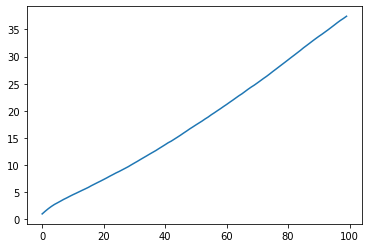

In [12]:
plt.plot(res)